# Relax User Adoption Study

Defining  an  *"adopted  user"*   as  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least  one  seven­day  period,  identify  which  factors  **predict  future  user adoption.**

**Data Sources:**

1. takehome_users(information about a given user and how their account was created)


2. takehome_user_engagement (row for each day a user logged into the product)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

%matplotlib inline

sns.set_style('darkgrid')

In [2]:
eng = pd.read_csv('takehome_user_engagement.csv')

users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [3]:
print(users.info())
users.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
print(eng.info())
eng.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


Several items of note appear after this initial look:


1.  I need to change several columns to datetime objects


2. Fill in missing values - if any.


3. I need to create some dummy variables for account creation source


4. I'll need to create several new features: 

    - Invited by a member of the same organization (y/n?)

    - Adopted user (y/n?) 

    - \# of logins prior to becoming 'adopted'

5. Examine last session time and understand how this feature translates into datetime values, if at all.

In [5]:
# Converting columns to datetime objects
users['creation_time'] = pd.to_datetime(users['creation_time'], format='%Y %m %d %H:%M:%S')
eng['time_stamp'] = pd.to_datetime(eng['time_stamp'], format='%Y %m %d %H:%M:%S')

# also converting the referral id to an integer and renaming the column to be easier to use

users.rename(columns = {'invited_by_user_id':'referral_id', 'object_id':'user_id'}, inplace=True)
users['referral_id'] = users['referral_id'].fillna(0)
users['referral_id'] = users['referral_id'].astype('int64')

In [6]:
print(users.info())
eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   referral_id                 12000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 937.6+ KB
None
<class 'pandas.core.frame.DataFrame

In [7]:
users.describe()

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,referral_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,3188.691333
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3869.027693
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,0.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,875.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,6317.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [8]:
eng.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


From the above we can see that the engagement dataframe is clean, and in fact we can drop the visited colum if needed since it's all identical.  For now I'm going to keep it since it may be useful for windown functions and resampling the time series information. 

It seems prodent to fill in the 'invited by user_id' as zero since there are no users with that ID and it will prevent any issues with null values later on.  

However I need to examine the 'last session created time' in order to asess how to impute those missing values. 

In [9]:
users.last_session_creation_time

0        1.398139e+09
1        1.396238e+09
2        1.363735e+09
3        1.369210e+09
4        1.358850e+09
             ...     
11995    1.378448e+09
11996    1.358275e+09
11997    1.398603e+09
11998    1.338638e+09
11999    1.390727e+09
Name: last_session_creation_time, Length: 12000, dtype: float64

This is in a unix timestamp format and I'll need to convert it back to the same formate as the other datetime objects in order to simplify working with the time data.  This will also allow me to impute the last login time from the engagement dataframe. 

In [10]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'],unit='s')

Next I need to fill in the missing values for 'last_session_creation_time'.  However, all the values from the engagement data that could be used to fill in this missing values only exist for users where we already have the 'last_session_creation_time'. I'll need to decide on another method to fill those values if needed.  However given that I'm missing 25% of the values there I'll wait to see how and if I need them before blindly choosing a method.

### Engineering Several Features

In [11]:
# Creating binary feature that indicates if a user was invited to join by a member of the same org

for i in users.index:
    if users.loc[i, 'referral_id'] != 0:
        ref = users.loc[i, 'referral_id'] #storing the referrer ID
        new_org = users.loc[i, 'org_id'] # storing the org ID for the user
        ref_org = users['org_id'][users['user_id'] == ref].iloc[0] # selecting the first value in a pandas series as the org ID for the referrer
        if ref_org == new_org:
                users.loc[i, 'org_referral'] = 1 # If the referrer org and user org match, value is 1
        else: 
            users.loc[i, 'org_referral'] = 0
    else:
        users.loc[i, 'org_referral'] = 0  

Next I need to define the 'adopted' feauture as a label for analysis.  In this instance it is whether or not a users has logged in on 3 distinct days within a given 7 day period. In this instance it does not matter when a 'week' begins or ends, which means that were we tobe using SQL I'd do this with a window function. 

In [12]:
# Creating a feature which indicated whether or not a users is 'adopted'
ids = list(eng.user_id.unique())
index = users.index
for i in ids:
    idx = users.index[users["user_id"] == i].tolist()[0]
    practice = eng[eng['user_id'] == i]
    practice = practice[['time_stamp', 'visited']]
    practice.index = practice['time_stamp']
    practice = practice.drop('time_stamp', axis=1)
    practice = practice.rolling('7d').sum()
    
    if len(practice[practice['visited'] >2]) >= 1:
        users.loc[idx, 'adopted'] = 1
    else:
        users.loc[idx, 'adopted'] = 0

In [13]:
# Showing what percent of users are considered adopted
print(str(round(users.adopted.sum()/12000 *100, 2)), 'percent of users are considered adopted.')

13.35 percent of users are considered adopted.


### Preprocessing

Here I need to prepare the data set for use with the ML models, and manipulate the datetime objects into new columns that are numeric and can be used by ML. 

I'll be dropping the features which cannot have any predictive power:  name, email, etc.  

I'll also need to break out the dates into new features with day/month/week of the year, year, and hour/second of the day, I'll also get out the day of the week. 

Finally, I'll create some dummy variables from a few other features that are categorical. 

In [14]:
ids = users['user_id']
data = users.drop(['user_id', 'org_id', 'name', 'email', 'referral_id'], axis=1)
data.head(3)

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_referral,adopted
0,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,1.0,0.0
1,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1.0,1.0
2,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,1.0,0.0


In [15]:
data['timedelta'] = data['last_session_creation_time'] - data['creation_time']
data.head(3)

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_referral,adopted,timedelta
0,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,1.0,0.0,0 days
1,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1.0,1.0,136 days
2,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,1.0,0.0,0 days


In [16]:
data.isna().sum()

creation_time                    0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_referral                     0
adopted                       3177
timedelta                     3177
dtype: int64

In [17]:
#I've found that there are missing values in the adopted column, as well as the last_login date columns and will
# drop those columns here
data = data.dropna()
# Encoding the categorical feature using on-hot for logistic regression, and label encoding for ensemble models

dummy  = pd.get_dummies(data['creation_source'], prefix = 'source')
le = LabelEncoder()
label_coded = pd.Series(le.fit_transform(data['creation_source']))
data = data.drop(['creation_source', 'creation_time', 'last_session_creation_time'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   opted_in_to_mailing_list    8823 non-null   int64          
 1   enabled_for_marketing_drip  8823 non-null   int64          
 2   org_referral                8823 non-null   float64        
 3   adopted                     8823 non-null   float64        
 4   timedelta                   8823 non-null   timedelta64[ns]
dtypes: float64(2), int64(2), timedelta64[ns](1)
memory usage: 413.6 KB


In [18]:
data['timedelta'] = pd.to_numeric(data['timedelta'].dt.days, downcast='integer')
data.head(3)

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_referral,adopted,timedelta
0,1,0,1.0,0.0,0
1,0,0,1.0,1.0,136
2,0,0,1.0,0.0,0


In [19]:
label_coded.isna().sum()

0

At this point I've created a data set from the provided data that will work with a ML model.  The next step is to build a basic predictive model and then forward select to include more data as needed to improve performance. 

### Building a basic predictive model.  

At this point we have engineered a new feature and cleaned up the original data.  The next step is to use a classification model to identify what features contribute to the determination of whether or not a user will adopt the software. 

The first step is to create a dummy classifier and will be used as a 'baseline' from which I can forward select additional features to include in the model. 

In [20]:
# starting with a small subset of the total data
X = data.drop(['adopted'], axis=1)
Y = data['adopted']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [21]:
dum = DummyClassifier()
dum.fit(x_train, y_train)
dpred = dum.predict(x_test)

print(classification_report(y_test, dpred, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1445
           1       0.00      0.00      0.00       320

    accuracy                           0.82      1765
   macro avg       0.41      0.50      0.45      1765
weighted avg       0.67      0.82      0.74      1765



/opt/anaconda3/envs/Basic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/Basic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/Basic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
logit = LogisticRegression(random_state=42, class_weight='balanced')
logit.fit(x_train, y_train)
lpred = logit.predict(x_test)

print(classification_report(y_test, lpred, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1445
           1       0.81      0.94      0.87       320

    accuracy                           0.95      1765
   macro avg       0.90      0.95      0.92      1765
weighted avg       0.96      0.95      0.95      1765



In [23]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
rpred = rf.predict(x_test)

print(classification_report(y_test, rpred, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1445
           1       0.87      0.87      0.87       320

    accuracy                           0.95      1765
   macro avg       0.92      0.92      0.92      1765
weighted avg       0.95      0.95      0.95      1765



In [24]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(x_train, y_train)
gpred = gb.predict(x_test)

print(classification_report(y_test, gpred, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1445
           1       0.92      0.88      0.90       320

    accuracy                           0.96      1765
   macro avg       0.95      0.93      0.94      1765
weighted avg       0.96      0.96      0.96      1765



It seems that the logistic regression model predicts the most adopted users, while the gradient boosting model doesn't uncover all adopted users it is more precise in which users it predicts as adopted.  Since both have recall scores over 85%, I'm going to work with moth models moving forward to forward select different subsets of the data. 

In [25]:
# adding label encoded data for the gradient boosting model
gbdata = pd.concat([data, label_coded], axis=1).dropna()
# adding one-hot encoded data for the logisting regression model
logitdata = pd.concat([data, dummy], axis=1)

In [26]:
# gb train/test split
X = gbdata.drop(['adopted'], axis=1)
Y = gbdata['adopted']


gbx_train, gbx_test, gby_train, gby_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

scaler = StandardScaler()
scaler.fit(gbx_train)
gbx_train = scaler.transform(gbx_train)
gbx_test = scaler.transform(gbx_test)
# logit train/test split
X = logitdata.drop(['adopted'], axis=1)
Y = logitdata['adopted']

lx_train, lx_test, ly_train, ly_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
cols = lx_train.columns
scaler = StandardScaler()
scaler.fit(lx_train)
lx_train = scaler.transform(lx_train)
lx_test = scaler.transform(lx_test)

In [27]:
logit = LogisticRegression(random_state=42, class_weight='balanced', )
logit.fit(lx_train, ly_train)
l_pred = logit.predict(lx_test)

print(classification_report(ly_test, l_pred, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1445
           1       0.82      0.94      0.88       320

    accuracy                           0.95      1765
   macro avg       0.90      0.95      0.92      1765
weighted avg       0.96      0.95      0.95      1765



In [28]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(lx_train, ly_train)
g_pred = gb.predict(lx_test)

print(classification_report(ly_test, g_pred, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1445
           1       0.93      0.88      0.91       320

    accuracy                           0.97      1765
   macro avg       0.95      0.93      0.94      1765
weighted avg       0.97      0.97      0.97      1765



I ultimately iterated and tried using the one-hot encoded data with the gradient boosting model since using label encoded data was not working well.  The result was that the model which performs best includes the on-hot encoded creation source data that is scaled.  Using this I'll examine the feature importances and take a look at which features most impact churn probability. 

In [29]:
gbweight = gb.feature_importances_
gbweight = pd.Series(gbweight, index = cols)
feat_ = gbweight.sort_values(ascending=False).head(10)
topten = list(gbweight.sort_values(ascending=False).head(10).index)

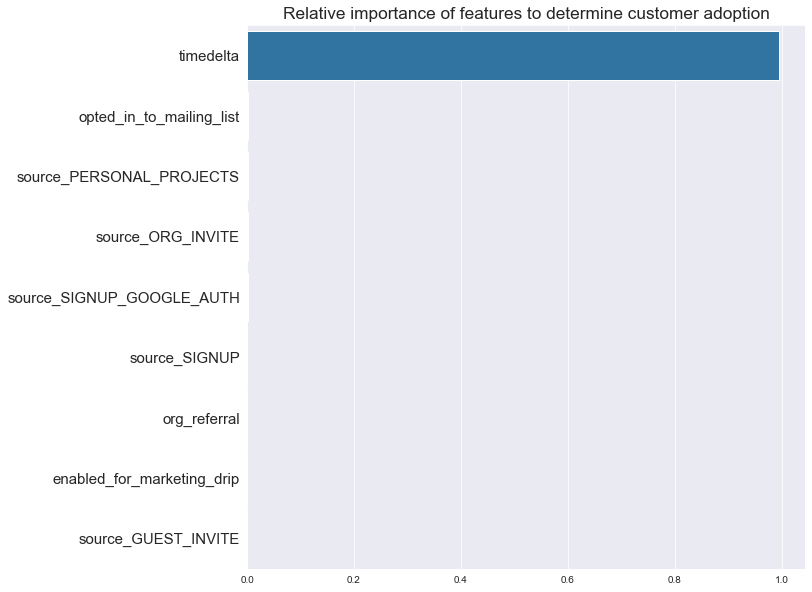

In [30]:
plt.figure(figsize=(10,10))

g = sns.barplot(x= feat_ ,y = topten, orient='h')
plt.title('Relative importance of features to determine customer adoption', size = 'xx-large')
g.set_yticklabels(topten, size = 15);

In [31]:
# creating a dictionary of feature column names and the logitistic regression coefficient to plot
dic = {'opted_in_to_mailing_list': 1.35187362e-01, 'enabled_for_marketing_drip':-2.34370254e-02, 
       'org_referral':1.18903974e-02, 'timedelta':9.65686070e+00, 'source_GUEST_INVITE':1.98120030e-02, 
       'source_ORG_INVITE':-3.57566456e-03, 'source_PERSONAL_PROJECTS':2.23950572e-02, 
       'source_SIGNUP':-7.36629716e-02,'source_SIGNUP_GOOGLE_AUTH':4.94749166e-02}
logit_coef = pd.Series(dic)
logit_coef = logit_coef.sort_values(ascending=False)
logit_coef

timedelta                     9.656861
opted_in_to_mailing_list      0.135187
source_SIGNUP_GOOGLE_AUTH     0.049475
source_PERSONAL_PROJECTS      0.022395
source_GUEST_INVITE           0.019812
org_referral                  0.011890
source_ORG_INVITE            -0.003576
enabled_for_marketing_drip   -0.023437
source_SIGNUP                -0.073663
dtype: float64

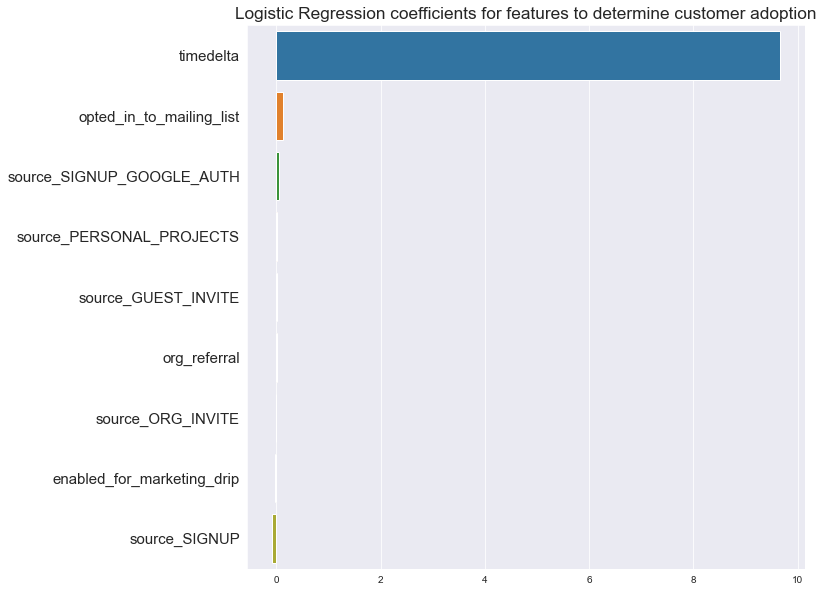

In [32]:
plt.figure(figsize=(10,10))

g = sns.barplot(x= logit_coef.values ,y = logit_coef.index, orient='h')
plt.title('Logistic Regression coefficients for features to determine customer adoption', size = 'xx-large')
g.set_yticklabels(logit_coef.index, size = 15);

Based on BOTH models the time from which a user signed up to their last login session is THE biggest determinator of whether or not a customer will be considered 'adopted'.  This is relatively obvious since someone who doesn't find value in the product won't be logging in much after trying out the service.  

While this is good to note, it's basically useless in terms of what kinds of insights may be offered to stakeholders who might wish to influence adoption rates among users.  For this purpose I'll be modelling the data again, however I'll do so after eliminating the timedelta feature and in order to examine the relative importance of other features (signup method and brand engagement) as long as one of the models provides a degree of accuracy that's similar to the models which incorporate the timedelta data. 

I do have a few predictions: 

- Signup method will be highly important, you can see in the logistic regression coefficients that of the top five most important features three are related to the source of the customer signup


- I'll need to examine org_referral vs source_ORG_INVITE in more detail.  One is capturing where a person used an organizational referral link to enroll in the service, while org_referral is simply tracking if a user was referred to the service by someone within their organization.  While a small distinction the second is more inclusive, and isn't limited to using a specific signup link, but rather if they noted themselves as having been referred by a coleague.  The latter was engineered by me.  If there is significant overlap between the two I may drop the source_ORG_INVITE since it's less inclusive. 

In [33]:
X = logitdata.drop(['adopted', 'timedelta'], axis=1)
Y = logitdata['adopted']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
cols = x_train.columns

In [34]:
logit = LogisticRegression(random_state=42, class_weight='balanced', )
logit.fit(x_train, y_train)
l2_pred = logit.predict(x_test)

print(classification_report(y_test, l2_pred, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1445
           1       0.22      0.33      0.26       320

    accuracy                           0.67      1765
   macro avg       0.53      0.54      0.52      1765
weighted avg       0.72      0.67      0.69      1765



In [35]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(x_train, y_train)
g2_pred = gb.predict(x_test)

print(classification_report(y_test, g2_pred, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1445
           1       0.00      0.00      0.00       320

    accuracy                           0.82      1765
   macro avg       0.41      0.50      0.45      1765
weighted avg       0.67      0.82      0.74      1765



/opt/anaconda3/envs/Basic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/Basic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/Basic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
params = {'C':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
          'fit_intercept':[True, False], 'intercept_scaling':[0.01, 0.1, 1, 2, 5, 10, 20]}
logit = LogisticRegression(class_weight = 'balanced', random_state = 42)
log = RandomizedSearchCV(logit, param_distributions = params, scoring = 'recall', n_iter = 60)
log.fit(x_train, y_train)
log_best_score = log.best_score_
log_best_params = log.best_params_
print('Best score: ', log_best_score)
print('Best parameters: ', log_best_params)

Best score:  0.6825389105058366
Best parameters:  {'intercept_scaling': 10, 'fit_intercept': False, 'C': 1e-05}


In [40]:
logit = LogisticRegression(class_weight='balanced', intercept_scaling = 10, fit_intercept = False, C = 1e-05, 
                           random_state = 42)
logit.fit(x_train, y_train)
l2_pred = logit.predict(x_test)

print(classification_report(y_test, l2_pred, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.83      0.37      0.51      1445
           1       0.19      0.66      0.29       320

    accuracy                           0.42      1765
   macro avg       0.51      0.51      0.40      1765
weighted avg       0.71      0.42      0.47      1765

